# Binary_correlation_plots

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re

import cptac
import cptac.utils as u

import plot_utils as p

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Select two cancers for the plot

In [2]:
g = cptac.Gbm()
brca = cptac.Brca()

cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 1)


In [3]:
def create_prot_list(df):
    df = df.loc[:,~df.columns.duplicated()]
    prot_genes_list = df.columns.values.tolist()
    prot_genes_list.remove('EGFR_proteomics')
    prot_genes_list.remove('EGFR_Mutation')
    prot_genes_list.remove('EGFR_Location')
    prot_genes_list.remove('EGFR_Mutation_Status')
    prot_genes_list.remove('Sample_Status')
    return prot_genes_list

# Calculate FDR-bh (lowest sig p-value = cutoff)

Gbm Pearson Correlation

In [4]:
gene = 'EGFR'
df1 = g.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes= gene)
#f1.columns = df1.columns.droplevel(1)
df1_tumor = df1.loc[df1['Sample_Status'] == "Tumor"]
prot_genes_list = create_prot_list(df1_tumor)


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 93 samples for the EGFR gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 2)


In [5]:
# Get only sig genes
g_sig= p.wrap_pearson_corr(df1_tumor,"EGFR_proteomics",comparison_columns= prot_genes_list,correction_method='fdr_bh', return_all = False)
g_sig
# get_smallest p-value
cutoff_gbm = g_sig.P_value[-1:]
cutoff_gbm

1571    0.007423
Name: P_value, dtype: float64

Brca Pearson Correlation

In [6]:
gene = 'EGFR'

df1 = brca.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes= gene)
df1.columns = df1.columns.droplevel(1)
df1_tumor = df1.loc[df1['Sample_Status'] == "Tumor"]
prot_genes_list = create_prot_list(df1_tumor)


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 118 samples for the EGFR gene (/Users/Lindsey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py, line 3)


In [7]:


# Get only sig sites
brca_sig= p.wrap_pearson_corr(df1_tumor,"EGFR_proteomics",comparison_columns= prot_genes_list,correction_method='fdr_bh', return_all = False)
brca_sig
# get_smallest p-value
cutoff_brca = brca_sig.P_value[-1:]
cutoff_brca

2057    0.013554
Name: P_value, dtype: float64

Read in data frame that has all pearson correlations/ pvalues for all egfr trans genes. Subset down for just brca/gbm 

In [8]:
prot_df = pd.read_csv("../Step3.2_combining_pearson_dfs/csv_files/pancan_EGFR_all_return_all_wide.csv")
prot_df = prot_df[["Comparison","Correlation_Gbm","P_value_Gbm","Correlation_Brca","P_value_Brca"]]

prot_df

,Comparison,Correlation_Gbm,P_value_Gbm,Correlation_Brca,P_value_Brca
0,EGFR_proteomics,1.000000,0.000000e+00,1.000000,0.000000
1,PHLDA1_proteomics,0.816848,6.553435e-25,0.364797,0.000190
2,GRB2_proteomics,-0.610889,1.886384e-11,-0.177379,0.057899
3,SOCS2_proteomics,0.562720,1.343464e-09,NaN,NaN
4,CDH4_proteomics,0.559180,1.790048e-09,NaN,NaN
...,...,...,...,...,...
14047,TFR2_proteomics,NaN,NaN,NaN,NaN
14048,MYBL2_proteomics,NaN,NaN,NaN,NaN
14049,ZSCAN12_proteomics,NaN,NaN,NaN,NaN
14050,ZNF836_proteomics,NaN,NaN,NaN,NaN


# Create df with p-values for all genes in a pathway

In [36]:
# get a list of genes in a complete Pathway 
#This one is from Reactomes Innate immune system pathway
df2 = u.search_reactome_proteins_in_pathways("R-HSA-168256.7")
immune_genes = df2.member.unique()

immune_all_genes = []
for gene in immune_genes:
    gene += "_proteomics"
    immune_all_genes.append(gene)

In [37]:
# Merge dfs of both cancers and keep only genes in a complete pathway
immune_bool = prot_df.Comparison.isin(immune_all_genes)
df = prot_df[immune_bool]
df

,Comparison,Correlation_Gbm,P_value_Gbm,Correlation_Brca,P_value_Brca
0,EGFR_proteomics,1.000000,0.000000e+00,1.000000,0.000000
2,GRB2_proteomics,-0.610889,1.886384e-11,-0.177379,0.057899
3,SOCS2_proteomics,0.562720,1.343464e-09,NaN,NaN
7,GLA_proteomics,-0.550491,3.570229e-09,0.069504,0.460453
8,CTSC_proteomics,-0.546285,4.951742e-09,0.266940,0.003928
...,...,...,...,...,...
13922,CD19_proteomics,NaN,NaN,NaN,NaN
13941,CD22_proteomics,NaN,NaN,NaN,NaN
13989,TGFA_proteomics,NaN,NaN,NaN,NaN
13994,DUSP1_proteomics,NaN,NaN,NaN,NaN


In [38]:
# Create pval only df for Color mapping
pval_df = df.drop(columns = ['Correlation_Gbm','Correlation_Brca'])
pval_df = pval_df.set_index('Comparison')
pval_df.head()

,P_value_Gbm,P_value_Brca
Comparison,,
EGFR_proteomics,0.000000e+00,0.000000
GRB2_proteomics,1.886384e-11,0.057899
SOCS2_proteomics,1.343464e-09,NaN
GLA_proteomics,3.570229e-09,0.460453
CTSC_proteomics,4.951742e-09,0.003928


# Create the color column based on significance in both cancers 

In [39]:
def Color(row):
    color = 'Not_sig'

    c1_cutoff = 0.007423# lowest p-value for cancer 1 (GBM)
    c2_cutoff = 0.013554 #Brca

    for item in row:
        if pd.isnull(item):
            continue
        if row['P_value_Brca'] <= c1_cutoff and row['P_value_Gbm'] <= c2_cutoff:
            color = 'Both_sig'
        elif row['P_value_Gbm'] <= c1_cutoff:
            color = 'Gbm_sig'
        elif row['P_value_Brca'] <= c2_cutoff:
            color = 'Brca_sig'
           
    return color

In [40]:
print('lowest p-value for GBM',cutoff_gbm, '\n')
print('lowest p-value for Brca:',cutoff_brca)

lowest p-value for GBM 1571    0.007423
Name: P_value, dtype: float64 

lowest p-value for Brca: 2057    0.013554
Name: P_value, dtype: float64


In [41]:
pval_df['Color'] = pval_df.apply(Color, axis=1)
color = pval_df[['Color']]
pval_df.head()

,P_value_Gbm,P_value_Brca,Color
Comparison,,,
EGFR_proteomics,0.000000e+00,0.000000,Both_sig
GRB2_proteomics,1.886384e-11,0.057899,Gbm_sig
SOCS2_proteomics,1.343464e-09,NaN,Gbm_sig
GLA_proteomics,3.570229e-09,0.460453,Gbm_sig
CTSC_proteomics,4.951742e-09,0.003928,Both_sig


# Format df for plot. Add color column and keep correlations.

In [42]:
color_df = color.reset_index()
plot_df = df.merge(color_df, on='Comparison')
plot_df= plot_df.drop(columns=['P_value_Gbm','P_value_Brca'])
plot_df.head()

,Comparison,Correlation_Gbm,Correlation_Brca,Color
0,EGFR_proteomics,1.000000,1.000000,Both_sig
1,GRB2_proteomics,-0.610889,-0.177379,Gbm_sig
2,SOCS2_proteomics,0.562720,NaN,Gbm_sig
3,GLA_proteomics,-0.550491,0.069504,Gbm_sig
4,CTSC_proteomics,-0.546285,0.266940,Both_sig


# Plot

In [43]:
def binary_corr_plot(prepared_df, x_axis_name, y_axis_name, title, save_file_name=None):
    
    color_dict = {'Both_sig':'green',
                  'Brca_sig':'yellow',
                  'Gbm_sig': 'blue',
                  'Not_sig': 'grey'}
    
    sns.set(font_scale = 1.2)
    #sns.axes_style("whitegrid")
    plt.figure(figsize=(10, 10))
    all_pvals = sns.scatterplot(x=prepared_df.columns[1], y=prepared_df.columns[2], data=prepared_df,
                               hue=prepared_df.columns[3], palette=color_dict)
    all_pvals.set_title(title)
        
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.xlim(-.7, .7) 
    plt.ylim(-.7, .7)
    
    if save_file_name is not None:
        plt.savefig(save_file_name+'.png')
    plt.show()
    #plt.clf()
    plt.close()
    return 0


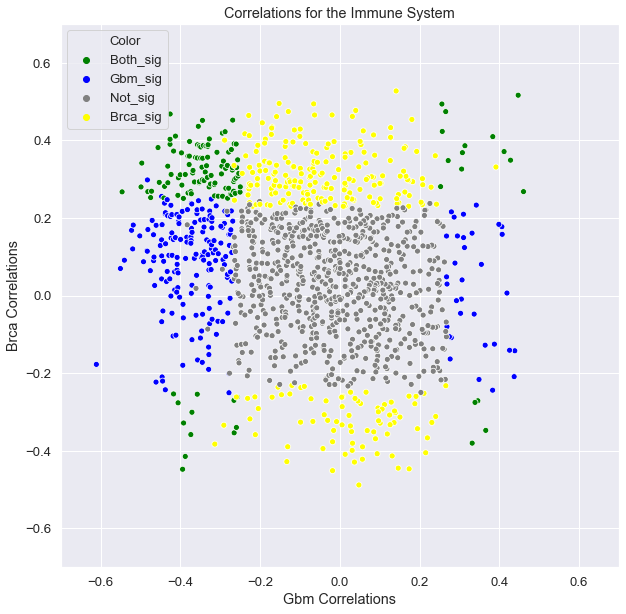

0

In [46]:
binary_corr_plot(plot_df, 'Gbm Correlations', 'Brca Correlations','Correlations for the Immune System')